In [1]:
from utils import vectorizers_order, vectorizers_order2, case_order, cases

input_dir_sa = '../logs/schema_agnostic/core/'
input_dir_ex = '../logs/schema_agnostic/extended/'
input_dir_bl = '../logs/baseline/'

In [2]:
import numpy as np
def export_legend(legend, filename="legend.png", expand=[-5,-5,5,5]):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)    

# Range of k

In [9]:
import json
import math
import statistics
import pandas as pd

stats = []
with open(input_dir_ex + 'k_range.txt') as f:
    for line in f:
        j = json.loads(line)
        j['ranks'] = [r+1 for r in j['ranks']] # add one since index is 0-based
        mean = math.ceil(statistics.mean(j['ranks']))
        median = math.ceil(statistics.median(j['ranks']))
        #print("{}:{} has mean {} and median {}".format(j['case'], j['vec'], mean, median))
        stats.append({'case': j['case'], 'vec': j['vec'], 'mean': mean, 'median': median})
        
stats = pd.DataFrame(stats)

t2 = stats.pivot(index='vec', columns='case', values='median').loc[vectorizers_order][case_order]
print(t2.to_latex())
t2

\begin{tabular}{lrrrrrrrrrr}
\toprule
case &  D1 &   D2 &   D3 &   D4 &    D5 &  D6 &    D7 &   D8 &   D9 &    D10 \\
vec            &     &      &      &      &       &     &       &      &      &        \\
\midrule
word2vec       &   1 &    3 &    7 &    1 &     2 &   1 &     1 &    1 &    2 &    282 \\
fasttext       &   1 &    3 &   16 &    1 &    50 &   1 &    32 &    1 &    1 &   3876 \\
glove          &   1 &    3 &    4 &    1 &     1 &   1 &     2 &    1 &    1 &   2125 \\
bert           &   1 &   22 &   97 &    1 &   388 &   1 &   263 &    1 &    4 &   3469 \\
albert         &   3 &  292 &  512 &   23 &  1072 &  13 &  1153 &   29 &  381 &   9828 \\
roberta        &   1 &  109 &  373 &    1 &  1139 &   1 &   662 &    1 &    1 &   1943 \\
distilbert     &   1 &   23 &   31 &    1 &   489 &   1 &   164 &    1 &    1 &   2312 \\
xlnet          &   7 &  534 &  643 &  295 &  2882 &  47 &  2560 &  333 &  791 &  13116 \\
smpnet         &   1 &    1 &    1 &    1 &     1 &   1 &     1

C:\Users\zeus8\AppData\Local\Temp\ipykernel_16992\2028052549.py:19: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(t2.to_latex())


case,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
vec,,,,,,,,,,
word2vec,1,3,7,1,2,1,1,1,2,282
fasttext,1,3,16,1,50,1,32,1,1,3876
glove,1,3,4,1,1,1,2,1,1,2125
bert,1,22,97,1,388,1,263,1,4,3469
albert,3,292,512,23,1072,13,1153,29,381,9828
roberta,1,109,373,1,1139,1,662,1,1,1943
distilbert,1,23,31,1,489,1,164,1,1,2312
xlnet,7,534,643,295,2882,47,2560,333,791,13116
smpnet,1,1,1,1,1,1,1,1,1,51


# Complementarity

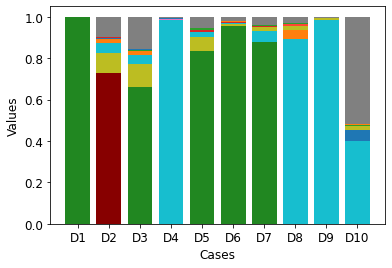

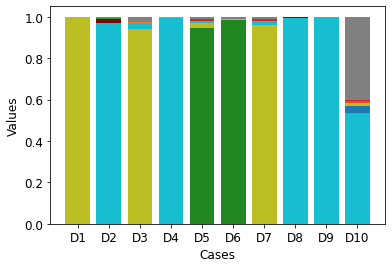

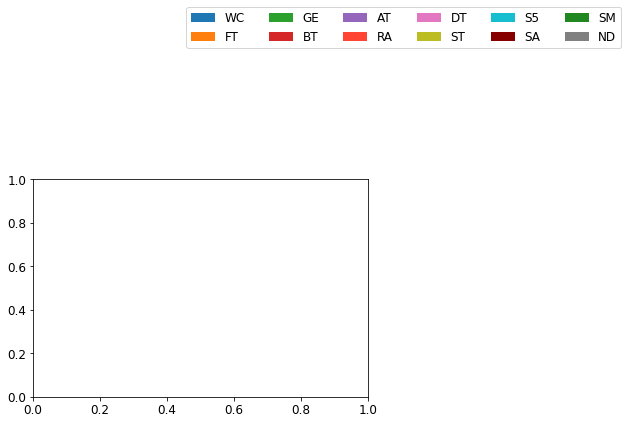

In [43]:
import json
import math
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import os

data = {k: {f'D{i}': {} for i in range(1, 11)} for k in [1, 10]}
with open(input_dir_ex + 'complementarity.txt') as f:
    for line in f:
        j = json.loads(line)
        data[j['k']][j['case']][j['vec']] = set([tuple(x) for x in j['ranks']])
     
for k in [1, 10]:

    total_stats = {}
    for nocase, (data1, data2, ground_file, sep, dir, cols) in enumerate(cases):
        nocase = f'D{nocase+1}'

        vecs = ['word2vec', 'fasttext', 'glove', 'bert', 'albert', 'roberta', 'distilbert', 'xlnet', 
                'smpnet', 'st5', 'sdistilroberta', 'sminilm',]
        
        vecs2 = ['WC', 'FT', 'GE', 'BT', 'AT', 'RA', 'DT', 'XT', 
        'ST', 'S5', 'SA', 'SM', 'ND']

        ground_file = '../data/real/{}/{}.csv'.format(dir, ground_file)
        ground_df = pd.read_csv(ground_file, sep=sep)
        ground_results = set(ground_df.apply(lambda x: (x[0], x[1]), axis=1).values)
        no_gr = len(ground_results)

        stats = []
        offset = 0
        for i in range(12):
            max_no_pairs, max_ind_vec, max_pairs = -1, -1, None
            for no_vec, vec in enumerate(vecs):
                found_pairs = data[k][nocase][vec] & ground_results
                if len(found_pairs) > max_no_pairs:
                    max_no_pairs, max_ind_vec, max_pairs = len(found_pairs), no_vec, found_pairs

            if max_no_pairs == 0: #nothing new to be found
                stats.append((nocase, 'not found', len(ground_results), offset + len(ground_results),
                              len(ground_results) / no_gr, (offset + len(ground_results)) / no_gr ))
                break            

            offset += max_no_pairs

            stats.append((nocase, vecs[max_ind_vec], max_no_pairs, offset, max_no_pairs / no_gr, offset / no_gr))
            ground_results = ground_results - max_pairs
            vecs.remove(vecs[no_vec])

            if len(ground_results) == 0: # found all pairs
                break
        total_stats[nocase] = stats

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#FF4433', '#e377c2', '#FFA500', '#bcbd22', '#17becf', '#870000', '#218721', '#808080']
    vecs = vectorizers_order + ['not found']
    color_vecs = {vec: color for vec, color in zip(vecs, colors)}

    fig, ax = plt.subplots()
    for case, stats in total_stats.items():
        for stat in stats:
            lab = (stat[1][0] + stat[1][-1]).upper()
            ax.bar([stat[0]], [stat[4]], bottom=[stat[5]-stat[4]], label=lab, color=[color_vecs[stat[1]]])

        # Customize plot
        ax.set_xlabel('Cases')
        ax.set_ylabel('Values')
#         ax.set_title('Complementarity')
        ax.legend()

    # Remove duplicates from legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.get_legend().remove()
    path = f'../plots_2/extended/complementarity_{k}.pdf'
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path, bbox_inches='tight')
    # Display the plot
    plt.show()        

fig = plt.figure()
fig.add_subplot(111)
patches = [by_label[m] for m in vecs2 if m in by_label]
leg = fig.legend(handles=patches, ncol=len(patches)//2, bbox_to_anchor=(1.5, 1.5))    
export_legend(leg, '../plots_2/extended/complementarity_legend.pdf')
plt.show()    


## Complementarity matrices

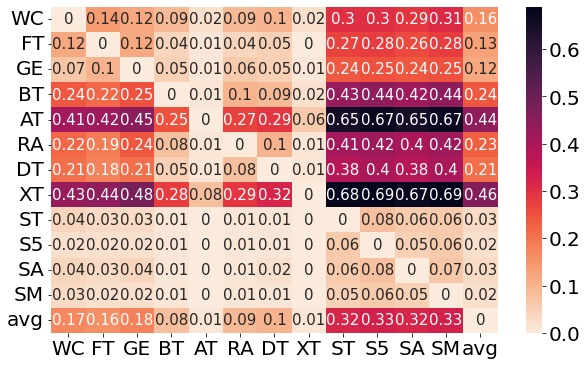

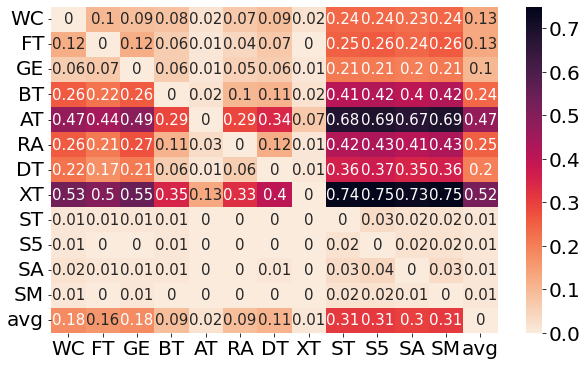

In [38]:
import json
import math
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

cmap = sns.cm.rocket_r
#cmap = sns.cm.rocket

vecs = ['word2vec', 'fasttext', 'glove', 'bert', 'albert', 'roberta', 'distilbert', 'xlnet', 
                'smpnet', 'st5', 'sdistilroberta', 'sminilm',]

for k in [1, 10]:
    gt_no = {}
    for nocase, (data1, data2, ground_file, sep, dir, cols) in enumerate(cases):
        nocase = f'D{nocase+1}'

        ground_file = '../data/real/{}/{}.csv'.format(dir, ground_file)
        ground_df = pd.read_csv(ground_file, sep=sep)
        ground_results = set(ground_df.apply(lambda x: (x[0], x[1]), axis=1).values)
        gt_no[nocase] = len(ground_results)
        
        for vec in vecs:
            data[k][nocase][vec] = data[k][nocase][vec] & ground_results
            
    total_stats = {}
    for nocase in data[k].keys():
        total_stats[nocase] = {}
        for vec1 in data[k][nocase].keys():
            for vec2 in data[k][nocase].keys():
                #total_stats[nocase][(vec1, vec2)] = len(data[nocase][vec2] - data[nocase][vec1]) / len(data[nocase][vec1]) # How much vec2 has to offer compared to what vec1 has already found
                total_stats[nocase][(vec1, vec2)] = len(data[k][nocase][vec2] - data[k][nocase][vec1]) / gt_no[nocase] # How much vec2 has to offer compared to what vec1 has already found
                
    total_df = pd.Series({(v1, v2): 0 for v1 in vectorizers_order for v2 in vectorizers_order}).unstack()
    for case in total_stats:
        df = pd.Series(total_stats[case]).unstack()
        total_df += df
    total_df = total_df / len(total_stats)
    total_df = total_df.loc[vectorizers_order, vectorizers_order]
    total_df.columns = [(v[0]+v[-1]).upper() for v in total_df.columns]
    total_df.index = [(v[0]+v[-1]).upper() for v in total_df.index]
    total_df = total_df.round(2)
    
    total_df_2 = total_df.copy()
    total_df_2['avg'] = total_df.apply(lambda x: x.sum() / (x.shape[0]-1), axis=1)
    total_df_2.loc['avg', :] = np.append(total_df.apply(lambda x: x.sum() / (x.shape[0]-1), axis=0).values, [0])
    total_df_2 = total_df_2.round(2)
    
    fig, ax = plt.subplots(figsize=(10, 6))            
    ax = sns.heatmap(total_df_2, annot=True, ax=ax, cmap = cmap, annot_kws={'size': 15})

    plt.savefig(f'../plots_2/extended/complementarity_matrix_{k}.pdf', bbox_inches='tight')

# Supervised effectiveness

In [3]:
import json
import pandas as pd

# SUPERVISED
lines = []
with open('../../logs/matching_supervised.txt') as f:
    for line in f:
        lines.append(json.loads(line))
with open('../../logs_revision/deep_matcher/log_dm.txt') as f:
    for line in f:
        lines.append(json.loads(line))
        
match_df_sup = pd.DataFrame(lines)
dirs = {'abt_buy' : 'DSM1', 'dirty_amazon_itunes' : 'DSM2', 'dirty_dblp_acm' : 'DSM3',
        'dirty_dblp_scholar' : 'DSM4', 'dirty_walmart_amazon' : 'DSM5'}

match_df_sup['data_dir'] = match_df_sup['data_dir'].apply(lambda x: dirs[x])
match_df_sup['model_type'] = match_df_sup['model_type'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_sup['f1'] = match_df_sup['f1'].apply(lambda x: x if x <= 1.0 else x/100)
match_df_sup['recall'] = match_df_sup['prfs'].apply(lambda x: x['class_1']['recall'] if not pd.isna(x) else None)



# UNSUPERVISED
match_df_unsup = pd.read_csv('../../logs/logs_extended/comparison_supervision_matching_unsupervised_euclidean.csv')
match_df_unsup['Vectorizer'] = match_df_unsup['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_unsup


# COMBINING
sup_stats = pd.DataFrame()
sup_stats['supervised_f1'] = match_df_sup[['f1', 'model_type', 'data_dir']].rename(columns={"model_type": "Vectorizer", "data_dir": "Case"}).set_index(['Vectorizer', 'Case'])

temp_df = match_df_unsup.loc[match_df_unsup.groupby(['Case', 'Vectorizer'])['F1'].idxmax().values].reset_index(drop=True)
sup_stats['unsupervised_f1_best'] = temp_df[['Case', 'Vectorizer', 'F1']].set_index(['Vectorizer', 'Case'])
temp_df = match_df_unsup.loc[match_df_unsup.groupby(['Case', 'Vectorizer'])['Delta'].idxmin().values].reset_index(drop=True)
sup_stats['unsupervised_f1_last'] =  temp_df[['Case', 'Vectorizer', 'F1']].set_index(['Vectorizer', 'Case'])

sup_stats = sup_stats.unstack()
sup_stats.columns.set_names(["Metric", "Case"], level=[0, 1], inplace=True)

sup_stats = sup_stats.reorder_levels(['Case', 'Metric'], axis=1)
sup_stats = sup_stats.sort_index(axis=1)
sup_stats = sup_stats.loc[vectorizers_order_2]
sup_stats

Case                DSM1                                            \
Metric     supervised_f1 unsupervised_f1_best unsupervised_f1_last   
Vectorizer                                                           
FT              0.626703             0.316472             0.298173   
GE              0.272494             0.273930             0.260460   
BT              0.842640             0.119441             0.113141   
AT              0.833333             0.007645             0.005893   
RA              0.865979             0.168994             0.153212   
DT              0.817259             0.120731             0.104891   
XT              0.863524             0.004714             0.004714   
ST              0.861619             0.558616             0.549204   
SA              0.861461             0.552221             0.544490   
SM              0.793651             0.562350             0.556276   

Case                DSM2                                            \
Metric     supervised_f1 unsupervised_f1_best unsupervised_f1_last   
Vectorizer                                                           
FT              0.720000             0.005764             0.001718   
GE              0.612245             0.006410             0.002004   
BT              0.925926             0.000358             0.000286   
AT              0.893617             0.000844             0.000286   
RA              0.961538             0.005780             0.000859   
DT              0.791667             0.004854             0.001145   
XT              0.892857             0.000000             0.000000   
ST              0.961538             0.016276             0.006013   
SA              0.830189             0.011025             0.004581   
SM              0.608696             0.009319             0.004295   

Case                DSM3                                            \
Metric     supervised_f1 unsupervised_f1_best unsupervised_f1_last   
Vectorizer                                                           
FT              0.969629             0.731352             0.721456   
GE              0.949608             0.711836             0.698842   
BT              0.987627             0.402921             0.384997   
AT              0.988713             0.167071             0.135135   
RA              0.981818             0.538065             0.516823   
DT              0.990971             0.636128             0.617761   
XT              0.986486             0.121897             0.121897   
ST              0.988764             0.723116             0.709322   
SA              0.979730             0.726452             0.719250   
SM              0.986456             0.728866             0.719801   

Case                DSM4                                            \
Metric     supervised_f1 unsupervised_f1_best unsupervised_f1_last   
Vectorizer                                                           
FT              0.924680             0.477506             0.467113   
GE              0.906944             0.464811             0.453375   
BT              0.948502             0.251185             0.248326   
AT              0.947765             0.064754             0.059420   
RA              0.956201             0.313679             0.303280   
DT              0.946729             0.378876             0.373691   
XT              0.952914             0.053581             0.053581   
ST              0.952381             0.496077             0.483256   
SA              0.955793             0.493397             0.481882   
SM              0.943432             0.504059             0.491156   

Case                DSM5                                            
Metric     supervised_f1 unsupervised_f1_best unsupervised_f1_last  
Vectorizer                                                          
FT              0.415430             0.275372             0.198083  
GE              0.245000             0.210583             0.161022  
BT         

In [10]:
import json
import pandas as pd

vectorizers_order3 = ['FT', 'GE', 'BT', 'AT', 'RA', 'DT', 'XT', 'ST', 'SA', 'SM']

# SUPERVISED
lines = []
with open(input_dir_sa + 'matching_supervised_dynamic.txt') as f:
    for line in f:
        lines.append(json.loads(line))
with open(input_dir_sa + 'matching_supervised_static.txt') as f:
    for line in f:
        lines.append(json.loads(line))
        
match_df_sup = pd.DataFrame(lines)
dirs = {'abt_buy' : 'DSM1', 'dirty_amazon_itunes' : 'DSM2', 'dirty_dblp_acm' : 'DSM3',
        'dirty_dblp_scholar' : 'DSM4', 'dirty_walmart_amazon' : 'DSM5'}

match_df_sup['data_name'] = match_df_sup['data_name'].apply(lambda x: dirs[x])
match_df_sup['model_type'] = match_df_sup['model_type'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_sup['f1'] = match_df_sup['f1'].apply(lambda x: x if x <= 1.0 else x/100)
match_df_sup['recall'] = match_df_sup['prfs'].apply(lambda x: x['class_1']['recall'] if not pd.isna(x) else None)



# UNSUPERVISED
lines = []
with open(input_dir_ex + 'supervision_matching.txt') as f:
    for line in f:
        lines.append(json.loads(line))

match_df_unsup = pd.DataFrame(lines)
match_df_unsup['vectorizer'] = match_df_unsup['vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_unsup.columns = [c.capitalize() for c in match_df_unsup.columns]

# COMBINING
sup_stats = pd.DataFrame()
sup_stats['supervised_f1'] = match_df_sup[['f1', 'model_type', 'data_name']].rename(columns={"model_type": "Vectorizer", "data_name": "Case"}).set_index(['Vectorizer', 'Case'])

sup_stats['unsupervised_f1'] = match_df_unsup[['F1', 'Vectorizer', 'Dataset']].rename(columns={"Dataset": "Case"}).set_index(['Vectorizer', 'Case'])

sup_stats = sup_stats.unstack()
sup_stats.columns.set_names(["Metric", "Case"], level=[0, 1], inplace=True)

sup_stats = sup_stats.reorder_levels(['Case', 'Metric'], axis=1)
sup_stats = sup_stats.sort_index(axis=1)
sup_stats = sup_stats.loc[vectorizers_order3]
sup_stats

Case                DSM1                          DSM2                  \
Metric     supervised_f1 unsupervised_f1 supervised_f1 unsupervised_f1   
Vectorizer                                                               
FT              0.626703        0.203883      0.720000        0.388060   
GE              0.272494        0.194156      0.612245        0.397059   
BT              0.842640        0.200580      0.925926        0.240000   
AT              0.833333        0.194156      0.893617        0.403101   
RA              0.865979        0.199067      0.961538        0.397059   
DT              0.817259        0.194156      0.791667        0.350000   
XT              0.863524        0.196540      0.892857        0.262295   
ST              0.861619        0.349711      0.961538        0.727273   
SA              0.861461        0.386087      0.830189        0.740741   
SM              0.793651        0.327169      0.608696        0.703704   

Case                DSM3                          DSM4                  \
Metric     supervised_f1 unsupervised_f1 supervised_f1 unsupervised_f1   
Vectorizer                                                               
FT              0.969629        0.888151      0.924680        0.823202   
GE              0.949608        0.867336      0.906944        0.764408   
BT              0.987627        0.595169      0.948502        0.477908   
AT              0.988713        0.434060      0.947765        0.334877   
RA              0.981818        0.717182      0.956201        0.579142   
DT              0.990971        0.781457      0.946729        0.640320   
XT              0.986486        0.404541      0.952914        0.331219   
ST              0.988764        0.867102      0.952381        0.817009   
SA              0.979730        0.889376      0.955793        0.828420   
SM              0.986456        0.885965      0.943432        0.839905   

Case                DSM5                  
Metric     supervised_f1 unsupervised_f1  
Vectorizer                                
FT              0.415430        0.257611  
GE              0.245000        0.172168  
BT              0.818653        0.193154  
AT              0.843501        0.172168  
RA              0.830846        0.191537  
DT              0.719577        0.170835  
XT              0.760095        0.172245  
ST              0.823529        0.230065  
SA              0.790000        0.237248  
SM              0.735294        0.287324

## Spider for Supervision Comparison

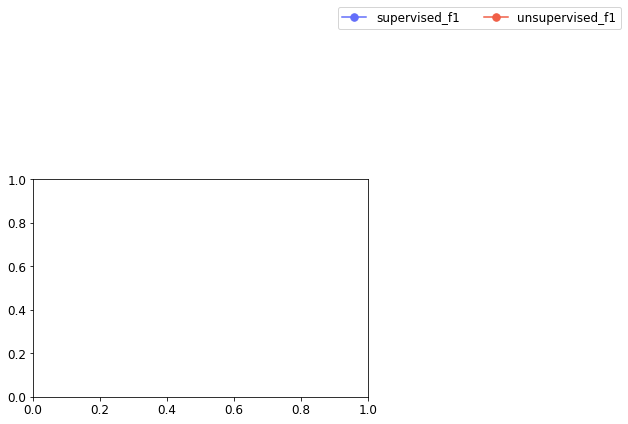

In [12]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 12, 'font.weight': 'normal'})

case_order2 = [f'DSM{i}' for i in range(1, 6)]
theta_case_order = case_order2 + [case_order2[0]]
for model, row in sup_stats.iterrows():
    
    temp_df = row.unstack()
    #print(temp_df)
    
    fig = go.Figure()
    fig.update_layout(font=dict(size=25,), 
                      polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                     #legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                     )

    for col in temp_df.columns:
        r = list(temp_df[col][case_order2].values)
        fig.add_trace(go.Scatterpolar(r=r+[r[0]], theta=theta_case_order, name=col))

    fig.update_layout(showlegend=False)
    fig.show()
    fig.write_image(f"../plots_2/extended/supervision_comparison_{model}.pdf")
    
fig = plt.figure()
fig.add_subplot(111)
#sub_methods = [('supervised_f1', '#636EFA'), ('unsupervised_f1_best', '#F05F47'), ('unsupervised_f1_last', '#00CC96')]
sub_methods = [('supervised_f1', '#636EFA'), ('unsupervised_f1', '#F05F47')]
leg = []
for (t, c) in sub_methods:
    leg.append(Line2D([], [], color=c, marker='.', fillstyle='full',  markersize=15, label=t))
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    
export_legend(leg, "../plots_2/extended/supervision_comparison_legend.pdf")  

# Blocking on Matching

In [ ]:
import pandas as pd

block_match_df = pd.read_csv('../../logs/logs_extended/matching_unsupervised_euclidean_block.csv')
block_match_df['Vectorizer'] = block_match_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
block_match_df_best = block_match_df.loc[block_match_df.groupby(['Case', 'Vectorizer', 'k'])['F1'].idxmax().values].reset_index(drop=True)
#block_match_df_best = block_match_df_best[['Case', 'Vectorizer', 'k', 'F1']].pivot(index=['Vectorizer'], columns=['k', 'Case'], values='F1')
#block_match_df_best


match_df = pd.read_csv('../../logs/matching_unsupervised_euclidean.csv')
match_df['Vectorizer'] = match_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
match_df_best = match_df.loc[match_df.groupby(['Case', 'Vectorizer'])['F1'].idxmax().values].reset_index(drop=True)
match_df_best['k'] = 'all'
#match_df

block_match_all = pd.concat([match_df_best[['Case', 'F1', 'k', 'Vectorizer']], block_match_df_best[['Case', 'F1', 'k', 'Vectorizer']]])
block_match_all = block_match_all[['Case', 'Vectorizer', 'k', 'F1']].pivot(index=['Vectorizer'], columns=['k', 'Case'], values='F1')
block_match_all

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20, 'font.weight': 'normal'})

for index, row in block_match_all.iterrows():
    #print(index, row)
    block_match_df_best2 = row.unstack().T
    
    theta_case_order = case_order + [case_order[0]]
    fig = go.Figure()
    fig.update_layout(font=dict(size=25,), 
                      polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                      legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                     )

    for col in block_match_df_best2.columns:
        r = list(block_match_df_best2[col][case_order].values)
        fig.add_trace(go.Scatterpolar(r=r+ [r[0]], theta=theta_case_order, name=col))

    #if k != 1:
    #    fig.update_layout(showlegend=False)
    fig.show()
    fig.write_image(f"../../plots_2/extended/blocking_matching_{index}.pdf")

# Blocking with Column Names

In [ ]:
import pandas as pd
block_df = pd.read_csv('../../logs/logs_extended/col_blocking.csv', index_col=0)

block_df['Vectorizer'] = block_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
block_df['F1'] = block_df.apply(lambda x: 2*x['Recall']*x['Precision'] / (x['Recall']+x['Precision']) if x['Recall']+x['Precision'] > 0 else 0, axis=1)
print(block_df.shape)
block_df

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20, 'font.weight': 'normal'})

for k in (1, 5, 10):
#for k in [10]:  
    
    block_df2 = block_df.loc[block_df.k == k]
    block_df2 = block_df2.pivot(index='Case', columns='Vectorizer', values='Recall')

    total_cols = {'SBERT': ['ST', 'S5', 'SA', 'SM']}

    theta_case_order = case_order + [case_order[0]]
    for grp, cols in total_cols.items():
        fig = go.Figure()
        fig.update_layout(font=dict(size=25,), 
                          polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                          legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                         )

        for col in cols:
            r = list(block_df2[col][case_order].values)
            fig.add_trace(go.Scatterpolar(r=r+ [r[0]], theta=theta_case_order, name=col))
        
        #if k != 1:
        #    fig.update_layout(showlegend=False)
        fig.show()
        fig.write_image(f"../../plots_2/extended/blocking_colnames_{k}_{grp}.pdf")

# Blocking Directionality

In [25]:
import pandas as pd
block_df = pd.read_csv(input_dir_ex + 'indexing.csv', index_col=0)

block_df['Vectorizer'] = block_df['Vectorizer'].apply(lambda x: x[0]+x[-1]).str.upper()
block_df['Direction'] = block_df['Direction'].apply(lambda x: x[0]).str.upper()
block_df['F1'] = block_df.apply(lambda x: 2*x['Recall']*x['Precision'] / (x['Recall']+x['Precision']) if x['Recall']+x['Precision'] > 0 else 0, axis=1)
print(block_df.shape)
block_df

(360, 10)


,Case,Columns,Vectorizer,k,Direction,Exact,Precision,Recall,F1,Time
0,D1,2,ST,1,R,exact,0.256637,0.977528,0.406542,2.247454
1,D1,2,ST,1,L,exact,0.038564,0.977528,0.074200,2.247454
2,D1,2,ST,1,B,exact,0.037317,1.000000,0.071948,2.247454
3,D1,2,ST,5,R,exact,0.051917,0.988764,0.098655,0.124962
4,D1,2,ST,5,L,exact,0.007890,1.000000,0.015657,0.124962
...,...,...,...,...,...,...,...,...,...,...
355,D10,2,SM,5,L,exact,0.079700,0.404059,0.133138,2.761682
356,D10,2,SM,5,B,exact,0.048319,0.454971,0.087360,2.761682
357,D10,2,SM,10,R,exact,0.037527,0.453265,0.069315,5.203175
358,D10,2,SM,10,L,exact,0.044112,0.447273,0.080304,5.203175


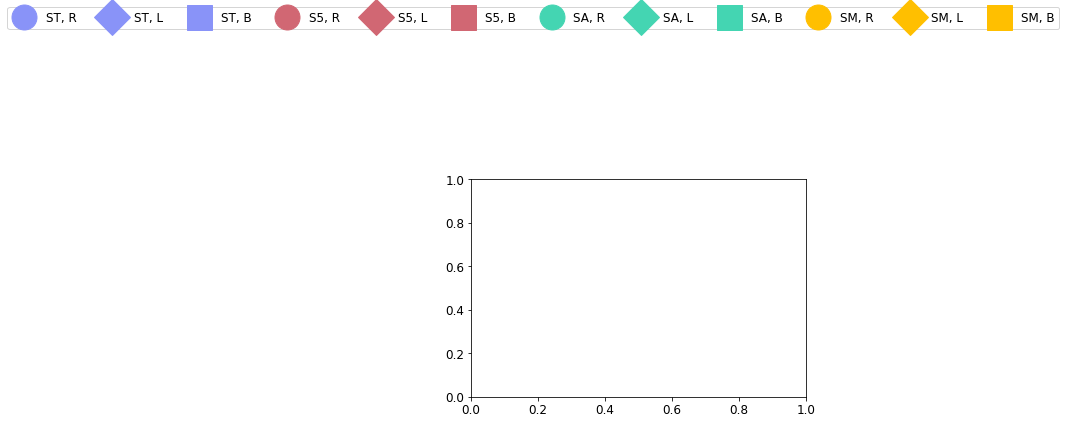

In [28]:
from matplotlib.lines import Line2D
import plotly.express as px

block_df['ID'] = block_df[['Vectorizer', 'k', 'Direction']].apply(lambda x: '({}, {}, {})'.format(x[0], x[1], x[2]), axis=1)
colors = {'SM': '#FF0000', 'ST': '#0000FF', 'S5': '#00FF00', 'SA': '#FFFF00'}
block_df['Size'] = 5

for case in block_df.Case.unique():
    block_df2 = block_df.loc[block_df.Case == case]

    fig1 = px.scatter(block_df2, y='Precision', x='Recall', hover_name='ID', color='Vectorizer', size='Size', symbol='Direction', text='k')
    fig1.update_layout(
                      font=dict(size=25,), 
                      #legend_title="",
                      #legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                      showlegend=False
                     )
    #, text=pareto.index, hover_name=pareto.index,, size='Size'
    fig1.show()
    fig1.write_image(f"../plots_2/extended/blocking_directionality_pareto_{case}.pdf")
    #break
    
fig = plt.figure()
fig.add_subplot(111)

colors = ['#8993F8', '#D16773', '#44D5B2', '#FFBF00']
#symbols = ['circle', 'diamond', 'square']
symbols = ['o', 'D', 's']
methods = ['ST', 'S5', 'SA', 'SM']
directions = ['R', 'L', 'B']

leg = []
for c, m in zip(colors, methods):
    for s, d in zip(symbols, directions):
        leg.append(Line2D([], [], color=c, marker=s, fillstyle='full',  markersize=25, label=f'{m}, {d}',
                         linestyle=''))
        
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    
export_legend(leg, "../plots_2/extended/blocking_directionality_pareto_legend.pdf")     

# Baseline

In [33]:
import json
import math
import statistics
import pandas as pd

base_stats = []
with open(input_dir_bl + 'TokenJoin.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'TokenJoin'
        base_stats.append(j)
with open(input_dir_bl + 'JedAI.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'kNN-Join'
        base_stats.append(j)
with open(input_dir_bl + 'Sparkly.txt') as f:
    for line in f:
        j = json.loads(line)
        j['vec'] = 'Sparkly'
        base_stats.append(j)        
df = pd.read_csv(input_dir_sa + 'blocking_euclidean_real.csv')
df = df.loc[df.Vectorizer =='st5']
df = df[['Case', 'k', 'Time', 'Precision', 'Recall', 'Vectorizer']]
df.columns = ['case', 'k', 'time', 'prec', 'rec', 'vec']
df.vec = 'S-GTR-T5'

deepblocker_df = []
with open(input_dir_bl + 'DeepBlocker.txt') as f:
    for line in f:
        deepblocker_df.append(json.loads(line))
deepblocker_df = pd.DataFrame(deepblocker_df)
deepblocker_df.columns = ['k', 'time', 'rec', 'prec', 'cands', 'col', 'case']
deepblocker_df['vec'] = 'DeepBlocker'
deepblocker_df


base_stats = pd.DataFrame(base_stats)
base_stats = pd.concat([base_stats, df, deepblocker_df])
base_stats

,case,k,time,prec,rec,f1,vec,cands,col
0,D1,1,0.822396,0.039573,1.000000,0.076133,TokenJoin,NaN,NaN
1,D1,5,2.166844,0.008208,1.000000,0.016282,TokenJoin,NaN,NaN
2,D1,10,5.154351,0.004420,1.000000,0.008801,TokenJoin,NaN,NaN
3,D2,1,10.138918,0.612454,0.612454,0.612454,TokenJoin,NaN,NaN
4,D2,5,31.098223,0.173420,0.867100,0.289033,TokenJoin,NaN,NaN
...,...,...,...,...,...,...,...,...,...
25,D9,5,103.734770,0.007244,0.962825,NaN,DeepBlocker,306765.0,aggregate value
26,D9,10,103.366248,0.003648,0.969844,NaN,DeepBlocker,613530.0,aggregate value
27,D10,1,150.035476,0.249625,0.253108,NaN,DeepBlocker,23182.0,aggregate value
28,D10,5,143.998526,0.067463,0.342020,NaN,DeepBlocker,115910.0,aggregate value


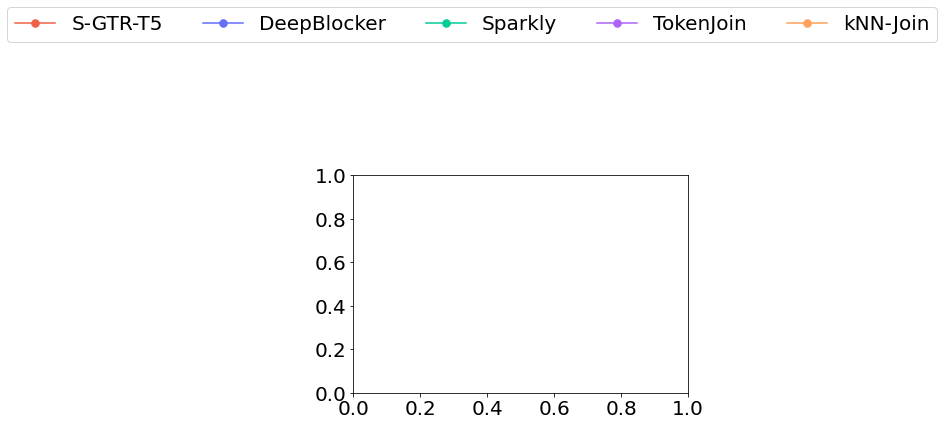

In [35]:
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 20, 'font.weight': 'normal'})

for k in (1, 5, 10):
    base_stats2 = base_stats.loc[(base_stats.k == k)]
    base_stats2 = base_stats2.pivot(index='case', columns='vec', values='rec')

    
    theta_case_order = case_order + [case_order[0]]
    fig = go.Figure()
    fig.update_layout(font=dict(size=25,), 
                      polar=dict(radialaxis=dict(dtick=0.2), angularaxis=dict(direction="clockwise", rotation=90)),
                      legend=dict(orientation="h", yanchor="bottom", y=1.10, xanchor="center", x=0.5),
                     )

    for col in base_stats2.columns:
        r = list(base_stats2[col][case_order].values)
        fig.add_trace(go.Scatterpolar(r=r+ [r[0]], theta=theta_case_order, name=col))

    fig.update_layout(showlegend=False)
    fig.show()
    fig.write_image(f"../plots_2/extended/blocking_{k}_baseline_.pdf")


fig = plt.figure()
fig.add_subplot(111)
sub_methods = [('S-GTR-T5', '#F05F47'), ('DeepBlocker', '#636EFA'), ('Sparkly', '#00CC96'), 
               ('TokenJoin', '#AB63FA'), ('kNN-Join', '#FFA15A')]
leg = []
for (t, c) in sub_methods:
    leg.append(Line2D([], [], color=c, marker='.', fillstyle='full',  markersize=15, label=t))
leg = fig.legend(handles=leg, ncol=len(leg), bbox_to_anchor=(1.5, 1.5))    
export_legend(leg, '../plots_2/extended/blocking_baseline_legend.pdf')
#plt.show() 